## Room downgrades / upgrades and how they affect the ADR
We want to check all the room type changes and see what type of room changes are affecting the most to the average daily rate.

Room Change Statistics:
No Change: 103848 bookings (87.94%)
Downgrade: 13622 bookings (11.54%)
Upgrade: 617 bookings (0.52%)

ADR by Room Change Status:
                          mean  median   count        std
room_change_status                                       
Downgrade            87.734124   80.00   13622  43.579877
No Change           105.642444   97.02  103848  46.373977
Upgrade             119.862836  108.11     617  42.691628

Room Change Percentage by Hotel Type:
room_change_status  Downgrade  No Change   Upgrade
hotel                                             
City Hotel           8.210147  91.168640  0.621213
Resort Hotel        18.225407  81.450687  0.323905

Room Type Transition Matrix (Reserved → Assigned):
assigned_room_type      A     B     C      D     E     F     G    H    I   K  \
reserved_room_type                                                             
A                   73158  1114  1408   7339  1107   403   174   91  119  96   
B                     

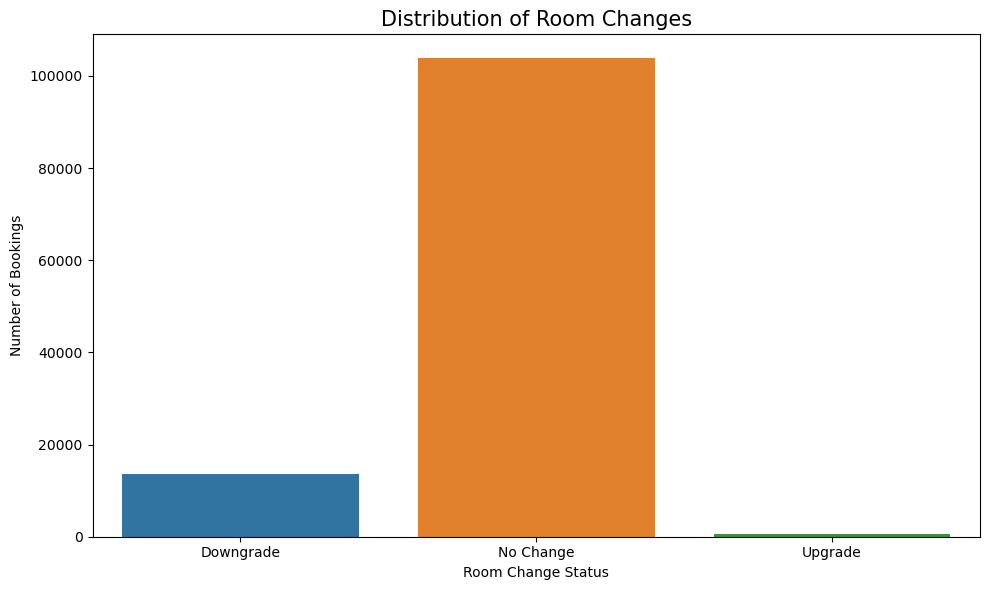

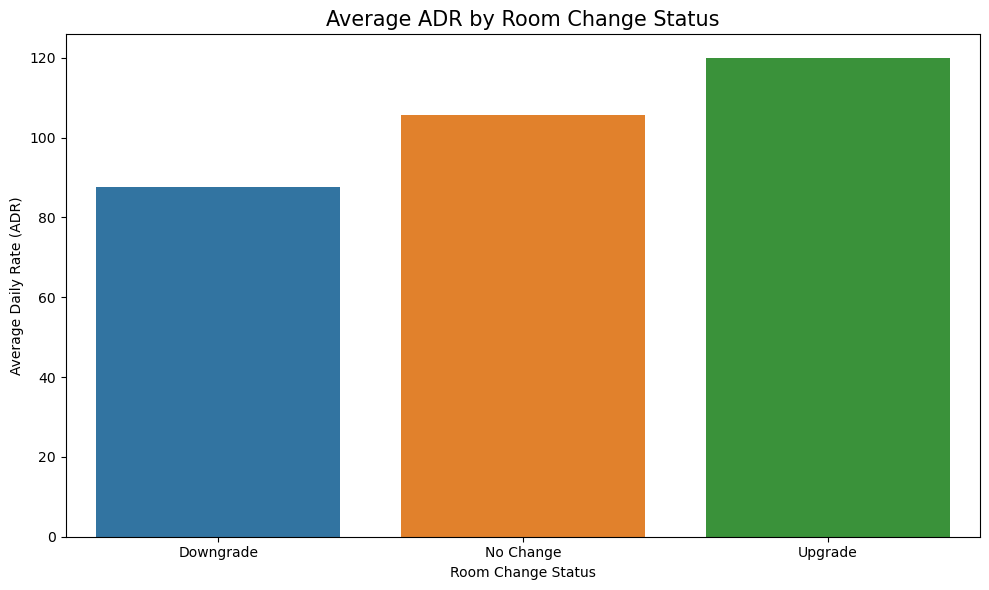

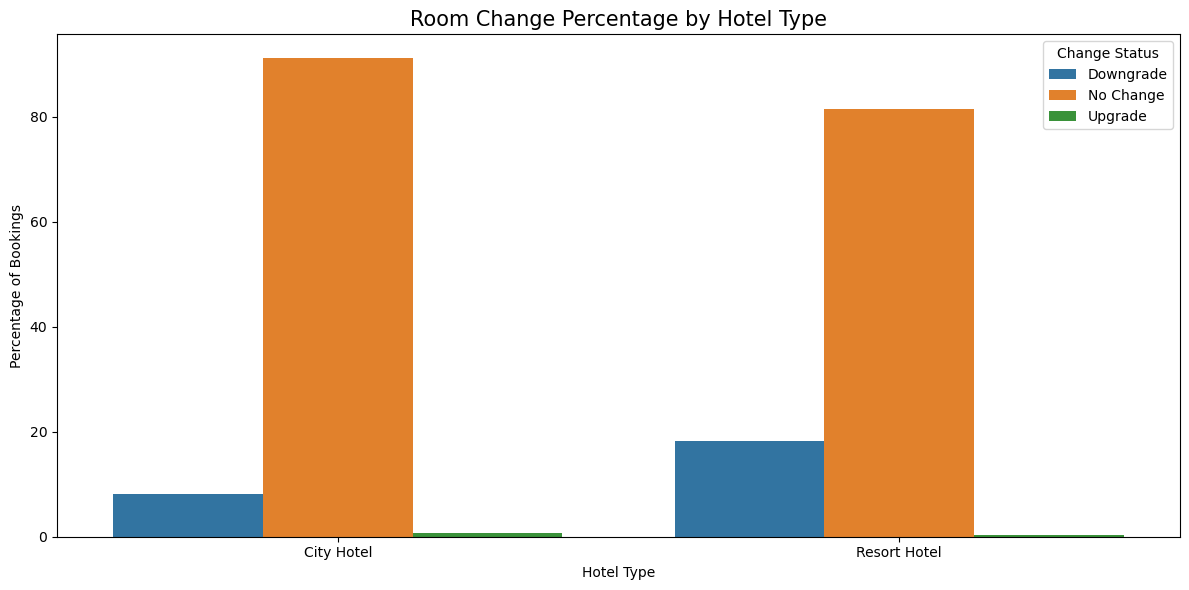

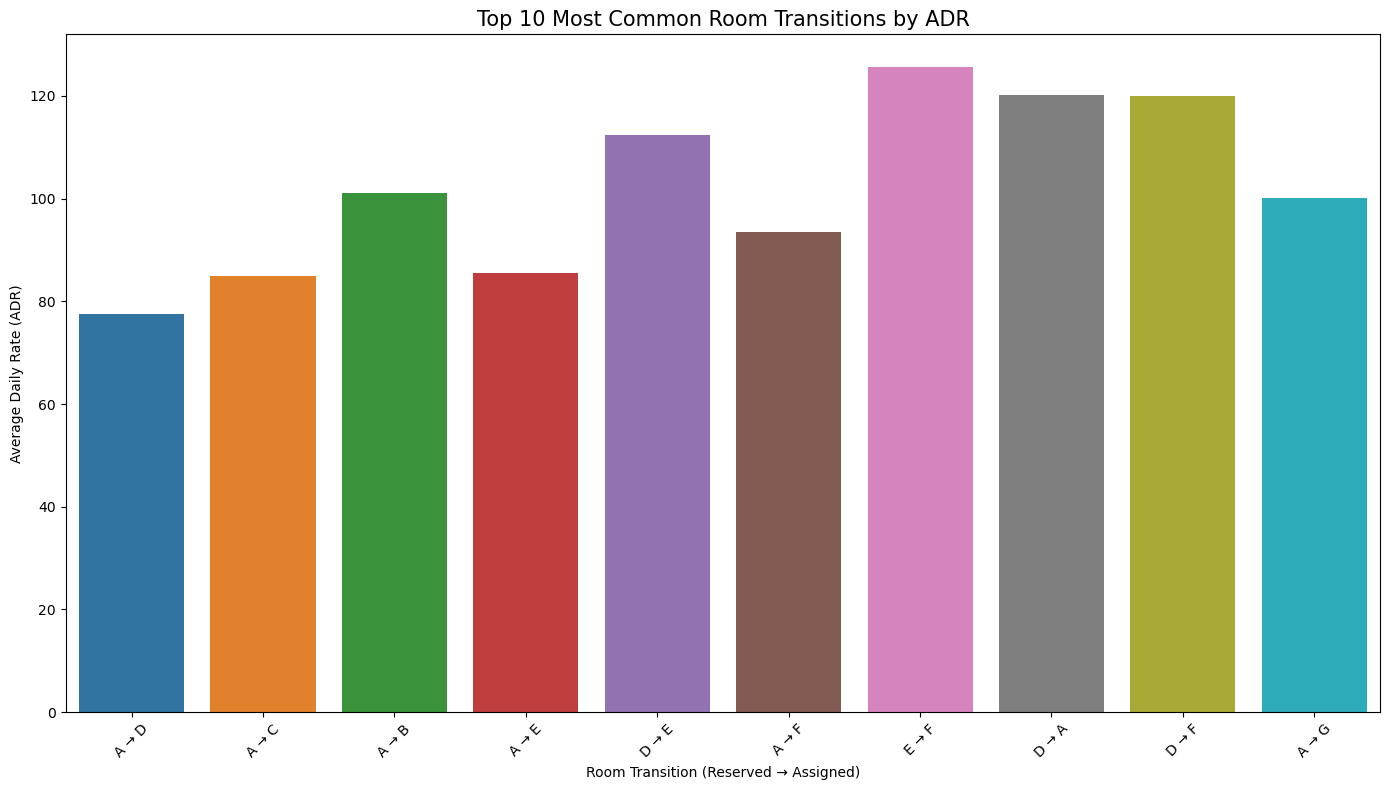

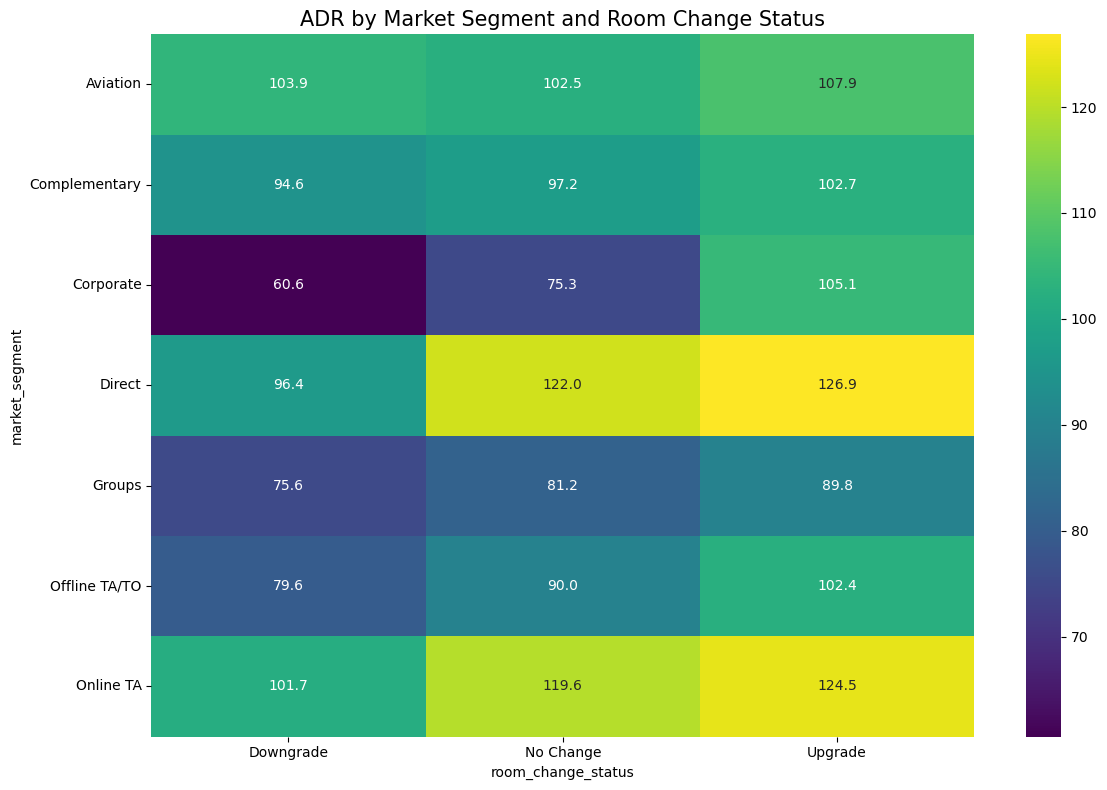


===== SUMMARY OF ROOM CHANGE ANALYSIS =====
1. Overall Impact of Room Changes on ADR:
   - Upgrades result in an average ADR increase of 14.22
   - Downgrades result in an average ADR decrease of 17.91

2. Most Profitable Room Transitions:
   1. H → H - ADR: 190.51 (582 bookings)
   2. G → G - ADR: 181.60 (2020 bookings)
   3. F → G - ADR: 177.17 (116 bookings)

3. Economic Impact:
   - Total estimated ADR impact from Upgrades: 3102.24
   - Total estimated ADR impact from Downgrades: -128743.40

Recommendations to optimize room assignment and ADR:
1. Prioritize certain room transition types that show higher ADR
2. Review room pricing strategy to align with actual value perception
3. Consider restricting downgrades for high-value market segments
4. Develop a strategic overbooking policy for room types frequently upgraded
5. Implement targeted upselling opportunities for specific room transitions


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('hotel_bookings_clean.csv', parse_dates=['arrival_date'])

# Create a room change status column
df['room_change_status'] = np.where(
    df['reserved_room_type'] == df['assigned_room_type'], 
    'No Change',
    np.where(
        df['reserved_room_type'] < df['assigned_room_type'], 
        'Downgrade', 
        'Upgrade'
    )
)

# Analysis 1: Overall statistics on room changes
room_change_counts = df['room_change_status'].value_counts()
room_change_pct = df['room_change_status'].value_counts(normalize=True) * 100

print("Room Change Statistics:")
for status, count in room_change_counts.items():
    print(f"{status}: {count} bookings ({room_change_pct[status]:.2f}%)")

# Analysis 2: ADR by room change status
adr_by_change = df.groupby('room_change_status', observed=True)['adr'].agg(['mean', 'median', 'count', 'std'])
print("\nADR by Room Change Status:")
print(adr_by_change)

# Analysis 3: Room change status by hotel type
hotel_change = pd.crosstab(df['hotel'], df['room_change_status'], normalize='index') * 100
print("\nRoom Change Percentage by Hotel Type:")
print(hotel_change)

# Analysis 4: Detailed room type changes
room_transitions = pd.crosstab(df['reserved_room_type'], df['assigned_room_type'])
print("\nRoom Type Transition Matrix (Reserved → Assigned):")
print(room_transitions)

# Analysis 5: ADR by specific room type transitions
# Group by reserved and assigned room types
transitions_adr = df.groupby(['reserved_room_type', 'assigned_room_type'], observed=True)['adr'].mean().reset_index()
transitions_adr['count'] = df.groupby(['reserved_room_type', 'assigned_room_type'], observed=True)['adr'].count().values
transitions_adr['transition'] = transitions_adr['reserved_room_type'] + ' → ' + transitions_adr['assigned_room_type']
transitions_adr['is_change'] = transitions_adr['reserved_room_type'] != transitions_adr['assigned_room_type']

# Filter to only show changes with sufficient data
significant_transitions = transitions_adr[transitions_adr['count'] > 100].sort_values('adr', ascending=False)
print("\nADR by Significant Room Type Transitions (min 100 bookings):")
print(significant_transitions[['transition', 'adr', 'count']])

# Analysis 6: Effect of room changes on customer satisfaction and special requests
customer_metrics = df.groupby('room_change_status', observed=True).agg({
    'total_of_special_requests': 'mean',
    'is_repeated_guest': 'mean'
}).reset_index()
print("\nCustomer Metrics by Room Change Status:")
print(customer_metrics)

# Analysis 7: ADR impact by market segment and room change status
segment_change_adr = df.groupby(['market_segment', 'room_change_status'], observed=True)['adr'].mean().reset_index()
segment_change_adr_pivot = segment_change_adr.pivot(index='market_segment', columns='room_change_status', values='adr')
print("\nADR by Market Segment and Room Change Status:")
print(segment_change_adr_pivot)

# Analysis 8: Economic impact of room changes
df['adr_impact'] = np.nan  # Will calculate this below

# For each room type, get the average ADR 
room_type_avg_adr = df.groupby('assigned_room_type', observed=True)['adr'].mean()

# Calculate the theoretical ADR if guests had the room they reserved
for idx, row in df.iterrows():
    if row['reserved_room_type'] != row['assigned_room_type']:
        original_room_avg_adr = room_type_avg_adr.get(row['reserved_room_type'], row['adr'])
        df.at[idx, 'adr_impact'] = row['adr'] - original_room_avg_adr

# Calculate total and average ADR impact
room_change_impact = df.groupby('room_change_status', observed=True)['adr_impact'].agg(['mean', 'sum'])
print("\nADR Impact of Room Changes:")
print(room_change_impact)

# ----- VISUALIZATIONS -----

# 1. Room Change Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='room_change_status', data=df, hue='room_change_status', legend=False)
plt.title('Distribution of Room Changes', fontsize=15)
plt.xlabel('Room Change Status')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. ADR by Room Change Status
plt.figure(figsize=(10, 6))
sns.barplot(x='room_change_status', y='mean', data=adr_by_change.reset_index(), 
           hue='room_change_status', legend=False)
plt.title('Average ADR by Room Change Status', fontsize=15)
plt.xlabel('Room Change Status')
plt.ylabel('Average Daily Rate (ADR)')
plt.tight_layout()
plt.show()

# 3. Room Change Status by Hotel Type
plt.figure(figsize=(12, 6))
hotel_change_melted = hotel_change.reset_index().melt(id_vars='hotel', var_name='change_status', value_name='percentage')
sns.barplot(x='hotel', y='percentage', hue='change_status', data=hotel_change_melted)
plt.title('Room Change Percentage by Hotel Type', fontsize=15)
plt.xlabel('Hotel Type')
plt.ylabel('Percentage of Bookings')
plt.legend(title='Change Status')
plt.tight_layout()
plt.show()

# 4. Top 10 Room Transitions by ADR
plt.figure(figsize=(14, 8))
top_transitions = transitions_adr[transitions_adr['is_change']].sort_values('count', ascending=False).head(10)
sns.barplot(x='transition', y='adr', data=top_transitions, hue='transition', legend=False)
plt.title('Top 10 Most Common Room Transitions by ADR', fontsize=15)
plt.xlabel('Room Transition (Reserved → Assigned)')
plt.ylabel('Average Daily Rate (ADR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. ADR Impact by Market Segment and Room Change
plt.figure(figsize=(12, 8))
sns.heatmap(segment_change_adr_pivot, annot=True, cmap='viridis', fmt='.1f')
plt.title('ADR by Market Segment and Room Change Status', fontsize=15)
plt.tight_layout()
plt.show()

# ----- SUMMARY AND RECOMMENDATIONS -----

print("\n===== SUMMARY OF ROOM CHANGE ANALYSIS =====")
print("1. Overall Impact of Room Changes on ADR:")
for status in ['Upgrade', 'Downgrade']:
    if status in adr_by_change.index:
        adr_diff = adr_by_change.loc[status, 'mean'] - adr_by_change.loc['No Change', 'mean']
        print(f"   - {status}s result in an average ADR {'increase' if adr_diff > 0 else 'decrease'} of {abs(adr_diff):.2f}")

print("\n2. Most Profitable Room Transitions:")
for i, (idx, row) in enumerate(significant_transitions.head(3).iterrows(), 1):
    print(f"   {i}. {row['transition']} - ADR: {row['adr']:.2f} ({row['count']} bookings)")

print("\n3. Economic Impact:")
if 'sum' in room_change_impact.columns:
    for status in ['Upgrade', 'Downgrade']:
        if status in room_change_impact.index and not np.isnan(room_change_impact.loc[status, 'sum']):
            print(f"   - Total estimated ADR impact from {status}s: {room_change_impact.loc[status, 'sum']:.2f}")

print("\nRecommendations to optimize room assignment and ADR:")
print("1. Prioritize certain room transition types that show higher ADR")
print("2. Review room pricing strategy to align with actual value perception")
print("3. Consider restricting downgrades for high-value market segments")
print("4. Develop a strategic overbooking policy for room types frequently upgraded")
print("5. Implement targeted upselling opportunities for specific room transitions")